# Introduction to Bamboo

*December 2021*

Bamboo is Python package for modelling the cooling systems of liquid rocket engines. 

Most of its functionality revolves around the `bamboo.engine.Engine` class. Full documentation is available at https://cuspaceflight.github.io/bamboo/.

### Contents: 
- <a href='#Simple Engine Example'>Simple Engine Example</a>
- <a href='#Running a cooling system analysis'>Running a cooling system analysis</a>

##  <ins> *Simple Engine Example* </ins> <a id='Simple Engine Example'></a>

We will start with an example of creating an Engine. 

To create an Engine object, we need to first create three sub-objects: 
- A <b>PerfectGas</b> object
- A <b>ChamberConditions</b> object
- A <b>Geometry</b> object

We will first import bamboo and any other modules we need, and will then specify the operating conditions for our engine.

In [1]:
import bamboo as bam
import numpy as np
import matplotlib.pyplot as plt
from CoolProp.CoolProp import PropsSI

'''Chosen operating points'''
pc = 10e5           # Chamber pressure (Pa)

'''From ProPEP 3 I got the following data on my exhaust gas'''
gamma = 1.264               # Ratio of specific heats cp/cv 
molecular_weight = 21.627   # Molecular weight of the exhaust gas (kg/kmol) 
Tc = 2458.89                # Chamber temperature (K)

### PerfectGas and ChamberConditions

To define our perfect gas, we must specify two of its properties. See the documentation available options. As of writing, the available keyword arguments are `gamma`, `molecular_weight` and `cp`.

To define our ChamberConditions, we need the chamber stagnation pressure `p0`, and the chamber stagnation temperature `T0`.

In [2]:
perfect_gas = bam.PerfectGas(gamma = gamma, molecular_weight = molecular_weight)
chamber_conditions = bam.ChamberConditions(p0 = pc, T0 = Tc)

### Geometry

To define the geometry of the engine, you must submit a list of x and y coordinates which represent the engine contour. These are given as two separate inputs `xs` and `ys`, to a `bamboo.engine.Geometry` class. The throat area is automatically found based on the minimum value in `ys`, and is used to calculate the choked mass flow rate of propellants when you set up an `Engine` object (later).

In this example we will use a simple conical nozzle. There is also a `rao` module available to automatically calculate the contour for a Rao bell nozzle.

In [3]:
xs = [-0.150, -0.050, 0.0, 0.025]         # The values in 'xs' must be in increasing order
rs = [0.045, 0.045, 0.02, 0.025]
geometry = bam.Geometry(xs = xs, rs = rs)

### Engine

We can now set up our `Engine` class and calculate simple properties such as thrust and specific impulse. To run an actual cooling analysis, we will need to specify more inputs, which is explained in the next section.

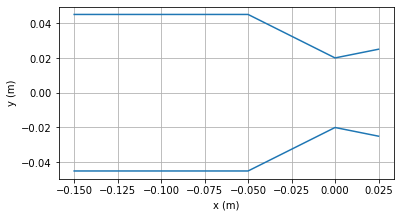

Sea level thrust = 1.5663165850173926 kN
Sea level Isp = 186.9831960913866 s

Throat pressure = 5.523188113751419 bar
Throat temperature = 2172.1643109540632 K
Throat Mach number = 1.0

Exit pressure = 1.6943397799012891 bar
Exit temperature = 1697.1004989216271 K
Exit Mach number = 1.8440672088887446


In [4]:
engine = bam.Engine(perfect_gas = perfect_gas, 
                    chamber_conditions = chamber_conditions, 
                    geometry = geometry)
engine.plot()
bam.show()

print(f"Sea level thrust = {engine.thrust(p_amb = 1e5)/1000} kN")
print(f"Sea level Isp = {engine.isp(p_amb = 1e5)/9.81} s")

print(f"\nThroat pressure = {engine.p(x = geometry.x_t)/1e5} bar")
print(f"Throat temperature = {engine.T(x = geometry.x_t)} K")
print(f"Throat Mach number = {engine.M(x = geometry.x_t)}")

print(f"\nExit pressure = {engine.p(xs[-1])/1e5} bar")
print(f"Exit temperature = {engine.T(xs[-1])} K")
print(f"Exit Mach number = {engine.M(xs[-1])}")

## <ins> *Running a cooling system analysis* </ins> <a id='Running a cooling system analysis'></a>

To run a cooling system analysis, we need to specify the following:
- Transport properties of the exhaust gas and the coolant, using the `TransportProperties` class.
- The wall thicknesses and materials, using a `Wall` class.
- The cooling jacket geometry, using the `CoolingJacket` class.

### Exhaust gas and coolant transport properties

You will need to decide on a way to calculate your exhaust gas and coolant transport properties. <b>CoolProp</b>, <b>thermo</b> and <b>Cantera</b> are Python modules that can help with this. In this example we'll use <b>CoolProp</b>.

You can either choose to use constants for your transport properties or functions. If using functions, you must submit your functions in the form <b>func(T, p)</b> where T is the temperature in K and p is pressure in Pa.

In [5]:
# We'll set up a very crude exhaust gas model using CoolProp - assuming the exhaust is pure nitrogen
# (we might do this if we were burning nitrous oxide with ethanol)

# Setup the exhaust gas transport properties
def Pr_exhaust(T, p):
    return PropsSI("PRANDTL", "T", T, "P", p, "NITROGEN")

def mu_exhaust(T, p):
    return PropsSI("VISCOSITY", "T", T, "P", p, "NITROGEN")

def k_exhaust(T, p):
    return PropsSI("CONDUCTIVITY", "T", T, "P", p, "NITROGEN")

exhaust_transport = bam.TransportProperties(Pr = Pr_exhaust,
                                            mu = mu_exhaust,
                                            k = k_exhaust)

# Set up the coolant transport properties - let's say this engine is water cooled
def Pr_coolant(T, p):
    return PropsSI("PRANDTL", "T", T, "P", p, "WATER")

def mu_coolant(T, p):
    return PropsSI("VISCOSITY", "T", T, "P", p, "WATER")

def k_coolant(T, p):
    return PropsSI("CONDUCTIVITY", "T", T, "P", p, "WATER")

def cp_coolant(T, p):
    return PropsSI("CPMASS", "T", T, "P", p, "WATER")

def rho_coolant(T, p):
    return PropsSI("DMASS", "T", T, "P", p, "WATER") 


coolant_transport = bam.TransportProperties(Pr = Pr_coolant,
                                            mu = mu_coolant,
                                            k = k_coolant,
                                            cp = cp_coolant,
                                            rho = rho_coolant)

Alternatively, we can also use constants for our transport properties:

In [6]:
#gas_transport = bam.cooling.TransportProperties(mu = 7.5e-5, 
#                                                k =  0.20, 
#                                                Pr = 0.62)

#coolant_transport = bam.cooling.TransportProperties(mu = 2.4e-3, 
#                                                    k = 0.14, 
#                                                    cp = 3000, 
#                                                    rho = 800,
#                                                    Pr = 7.56)

### Walls

You can specify the walls of the engine to either have a constant thickness (by submitting a float), or having a variable thickness. To specify a variable thickness, you must submit a function to the `thickness` argument when setting up the Walls class. This function must take the x-position as an argument.

You can either add a single wall, or multiple walls by submitting a list of walls to the `Engine` class. In this example we'll use two walls.

In [7]:
copper = bam.Material(E = 117e9, poisson = 0.34, alpha = 16.9e-6, k = 391.2)
stainless_steel = bam.Material(E = 193e9, poisson = 0.29, alpha = 16e-6, k = 14.0)

def variable_thickness(x):
    fraction = (x - xs[0]) / (xs[-1] - xs[0])
    return 4e-3 * (1 - fraction) + 1e-3

inner_wall = bam.Wall(material = copper, thickness = 2e-3)
outer_wall = bam.Wall(material = stainless_steel, thickness = variable_thickness)   # Thickness that decreases with increasing x

### Cooling jacket

This specifies the cooling jacket geometry. We can choose a `'spiral'` cooling jacket (<a href='https://www.researchgate.net/publication/334702281/figure/fig3/AS:784891427971073@1564144107544/Structure-of-Zawiszas-regenerative-cooled-chamber.jpg'>example</a>), or a `'vertical'` cooling jacket (<a href='https://slideplayer.com/slide/4179683/14/images/6/Cooling+Channels.jpg'>example</a>).

We can choose to only have the cooling jacket over a limited region of the engine using the `xs` argument to the `CoolingJacket` object. e.g. using `xs = [0, 0.5]` means the cooling jacket will only be present from x = 0 to x = 0.5.

In [8]:
'''Cooling jacket properties'''
inlet_T = 298.15                           # Coolant inlet static temperature (K)
inlet_p = 30e5                             # Coolant inlet static pressure (bar)
OF_ratio = 3.5                             # Oxidiser/fuel mass ratio
mdot_coolant = engine.mdot/(OF_ratio + 1)  # Mass flow rate of coolant

'''Add a spiral cooling jacket to the engine'''
# See the documentation for a full list of cooling jacket options
cooling_jacket = bam.CoolingJacket(T_coolant_in = inlet_T, 
                                  p_coolant_in = inlet_p, 
                                  mdot_coolant = mdot_coolant, 
                                  channel_height = 5e-3,
                                  channel_width = 10e-3,
                                  blockage_ratio = 0.3,
                                  restrain_fins = True,
                                  coolant_transport = coolant_transport,
                                  configuration = 'spiral')

## Running a steady state heating simulation

We can now set up the full `Engine` object, and run a steady state heating simulation with ease. This uses 1-D radial thermal circuit theory to find the heat transfer through the wall, and temperatures at each point.

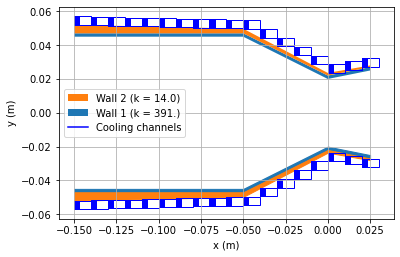

<ipython-input-9-bc6e1caf1679>:14: UserWarning: More than one wall is present. Thermal stresses calculations will ignore any incompatibility in different thermal expansions.
  cooling_data = engine.steady_heating_analysis()



Coolant exit temperature: 407.9505608386769 K

dict_keys(['info', 'x', 'T', 'T_coolant', 'T_exhaust', 'dQ_dx', 'dQ_dLc', 'dQ_dA', 'Rdx', 'p_coolant', 'rho_coolant', 'V_coolant', 'Dh_coolant', 'sigma_t_thermal', 'sigma_t_pressure', 'sigma_t_max', 'r'])

Information on the 'T' key:
Static temperature at each position (K). T[i][j], is the temperature at x[i], at the j'th wall boundary. j = 0 corresponds to the coolant, j = -1 corresponds to the exhaust gas.


In [9]:
engine = bam.Engine(perfect_gas = perfect_gas, 
                    chamber_conditions = chamber_conditions, 
                    geometry = geometry,
                    exhaust_transport = exhaust_transport,
                    cooling_jacket = cooling_jacket,
                    walls = [inner_wall, outer_wall],
                    coolant_convection = "gnielinski",
                    exhaust_convection = "bartz-sigma")

engine.plot()
bam.show()

# Run the heating analysis - see the documentation for details on the various arguments.
cooling_data = engine.steady_heating_analysis()

print(f"\nCoolant exit temperature: {cooling_data['T_coolant'][-1]} K")

# Print of the keys so we can see what data is available
print("")
print(cooling_data.keys())

# We can get information on what each key means, with the 'info' key.
print("\nInformation on the 'T' key:")
print(cooling_data["info"]["T"])

Plot the results:

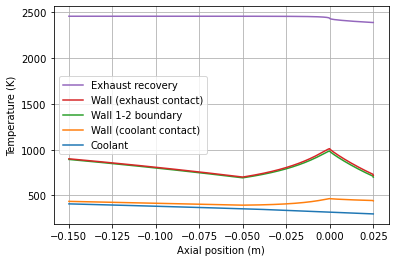

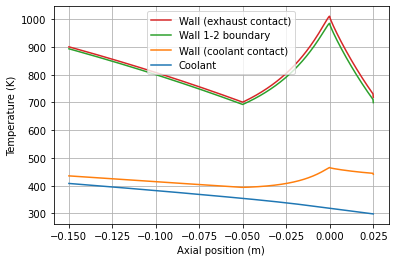

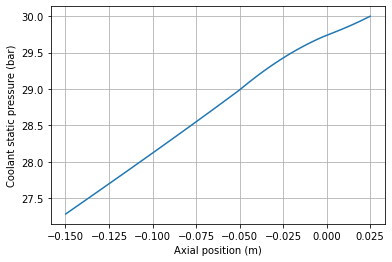

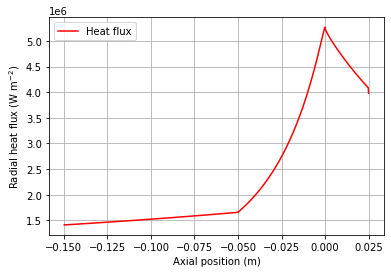

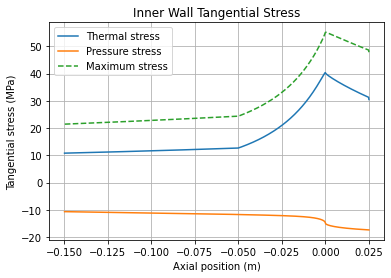

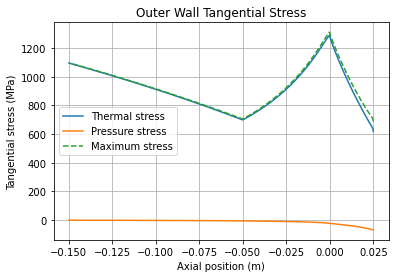

In [10]:
#Use the built in plotting functions to quickly generate some plots
bam.plot.plot_temperatures(cooling_data)
bam.show()

bam.plot.plot_temperatures(cooling_data, only_indexes = [0, 1,2,3])   # Exclude the exhaust gas temperature from the plot
bam.show()

bam.plot.plot_p_coolant(cooling_data)
bam.show()

bam.plot.plot_q_per_area(cooling_data)
bam.show()

bam.plot.plot_tangential_stress(cooling_data, wall_index = 0)
plt.title("Inner Wall Tangential Stress")
bam.show()

bam.plot.plot_tangential_stress(cooling_data, wall_index = 1)
plt.title("Outer Wall Tangential Stress")
bam.show()